# Experimental: Method to calculate the delay days (=recovery period) per country

In [1]:
import matplotlib.pylab as plt
import numpy as np
import plotly as py
import plotly.graph_objs as go
import pandas as pd
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

import covsirphy as cs
cs.__version__

'2.15.0'

## Load data

In [3]:
data_loader = cs.DataLoader(directory="kaggle/input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()
# Description/citation
print(oxcgrt_data.citation)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/

Please set verbose=2 to see the detailed citation list.


Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan
(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


## Estimate number of days of delay for a given country

In [4]:
country = "Japan"
scn = cs.Scenario(jhu_data, population_data, country)

indicators = oxcgrt_data.cleaned().columns.values[1:]
print("Indicators: ", indicators)

records = scn.records(show_figure=False)
print("Targets: ", records.columns.values[1:])

Indicators:  ['Country' 'ISO3' 'School_closing' 'Workplace_closing' 'Cancel_events'
 'Gatherings_restrictions' 'Transport_closing' 'Stay_home_restrictions'
 'Internal_movement_restrictions' 'International_movement_restrictions'
 'Information_campaigns' 'Testing_policy' 'Contact_tracing'
 'Stringency_index']
Targets:  ['Infected' 'Fatal' 'Recovered']


In [5]:
indicator, target = "Stringency_index", "Infected"
days, df_periods = scn.estimate_delay(oxcgrt_data, indicator=indicator, target=target)

In [6]:
print("Days of delay for", country, ":", round(days, 2))

Days of delay for Japan : 14


## View the calculated periods in a graph

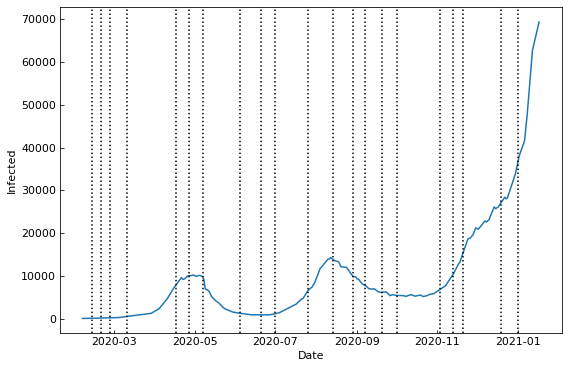

In [7]:
df_periods["Cumulative days"] = df_periods["Period Length"].cumsum()

plt.plot(records["Date"], records[target])
plt.xlabel("Date")
plt.ylabel(target)
plt.title(target + "over time with change periods")

start_date = records["Date"].values[0]
for day in df_periods["Cumulative days"].values[1:].astype(int):
    plt.axvline(start_date + np.timedelta64(day, 'D'), linestyle=":", color="black")


## Calculate delay days for every country

In [8]:
countries = jhu_data.cleaned()["Country"].unique()
delay_days = {}

for country in countries:
    try:
        sn = cs.Scenario(jhu_data, population_data, country)
    except:
        print("Skipped", country)
        continue
        
    days, df_periods = sn.estimate_delay(oxcgrt_data, indicator=indicator, target=target)
    delay_days[country] = days

Skipped American Samoa
Skipped Others
Skipped South Korea
Delay days could not be estimated for Marshall Islands , delay set to default:  16
Delay days could not be estimated for MS Zaandam , delay set to default:  16
Delay days could not be estimated for Samoa , delay set to default:  16


In [14]:
data = dict (
    type = 'choropleth',
    locations = list(delay_days.keys()),
    locationmode='country names',
    z=list(delay_days.values()),
    colorscale=px.colors.named_colorscales()[9],
    colorbar=dict(thickness=30,
                           ticklen=7,
                           tickfont=dict(size=20)),
)

map = go.Figure(data=[data], 
                        layout = go.Layout(
                        title="Average number of delay days calculated with change in " + target + " and " + indicator,
                        geo=dict(bgcolor= 'rgba(233,233,233,0.3)')))

py.offline.iplot(map)

In [10]:
print(np.mean(list(delay_days.values())))

13.387755102040817
